# Outline
## From last time:  
1. Can start with simple models: generating frequency features from the data, start from binary classification. Figure out how long of the segment is needed to perform classification .Have a baseline until I read the papers
2. Define your own measure; check some of the classifiers that tell you it doestnt know a class
3. Read several papers, see how MEG is compared to other data like voice. Maybe read survey papers? try NN baseline?

## What's next:

1. how small the segment should be? can we use a subset of channels?
2. read papers about MEG/EEG classification





### The data

- Data is downsampled (20 pts for a word). 
- Fourth run is held. Detrended; 1700 words per run (each run is different)
- In linear analysis make sure the runs are exchangeable. (maybe fourth run is worse). See if there is any differences among runs (variances, etc)
- Subject 1 3 5: missing first 700 words. 2 ,4 ,6: missing last 700 words
- The data has been preprocessed: averaged, detrended, etc
- The last two subjects are messy, don’t  touch them until Leila updated a new version
- see Loading_Harry_Potter_MEG


In [1]:
from IPython.display import Math
from IPython.display import Latex



### Formally phrase the classification problem: 

 Given MEG data from $K$ subjects: $M_{i\in [K]}\in \mathbf{R}^{n\times s \times p} $, where $n$ is the number of words, $s$ is the number of sensor, $p$ is the number of sampling points for eath word. We would like to have a function $f$: $M_{new}\rightarrow j \in [K]$ where $M_{new} \in \mathbf{R}^{n'\times s' \times p'} $ and $n', s', p'$ could be different from $n, s, p$
A simple version to begin with is when $K=2$.


(at first we only consider the MEG data partitioned into intervals of stimuli)

### Data visualization

In [3]:
#import cortex
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import scipy.io as sio


# local directory# local 
path = '/Users/wsh/Desktop/research/brain_ml/'
# subject number
subject_num = 3
filename = os.path.join(path, 'subset_MEG.mat')


mat = sio.loadmat(filename)
data = mat['train_data']
data=data[:6,]
print(data.shape)

data1=data[0][np.std(data[0],axis=(1,2))>0][0:3010]
data2=data[1][np.std(data[1],axis=(1,2))>0][0:3010]
data3=data[2][np.std(data[2],axis=(1,2))>0][0:3010]
data4=data[3][np.std(data[3],axis=(1,2))>0][0:3010]
data5=data[4][np.std(data[4],axis=(1,2))>0][0:3010]
data6=data[5][np.std(data[5],axis=(1,2))>0][0:3010]

In [206]:
%matplotlib 

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    plt.subplot(2,1,1)
    plt.imshow(data1[i,:,:],aspect = 'auto',vmin = -0.5,vmax = 0.5)
    plt.subplot(2,1,2)  
    plt.imshow(data3[i,:,:],aspect = 'auto',vmin = -0.5,vmax = 0.5)

    
ani = animation.FuncAnimation(fig, animate, interval=500)
plt.show()

Using matplotlib backend: MacOSX


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### A simple task: binary classification

#### I picked the first two subjects, concatenate every 5 words (so that for each subject, the data has shape [number of words/5, 306 channels, 20*5 sampling points]
#### I then used the Python library cesium to perform feature extraction on the time series data, trained a simple random forest and performed a 5-fold cross-validation. The testing accuracy is 98.75%
#### code ref: https://github.com/cesium-ml/cesium/tree/master/examples


In [58]:
data1_reshaped=np.swapaxes(data1,0,1)
data1_reshaped=np.reshape(data1_reshaped,[-1,int(data1.shape[0]/5),100] )
data1_reshaped=np.swapaxes(data1_reshaped,0,1)
data1_reshaped.shape

data2_reshaped=np.swapaxes(data2,0,1)
data2_reshaped=np.reshape(data2_reshaped,[-1,int(data2.shape[0]/5),100] )
data2_reshaped=np.swapaxes(data2_reshaped,0,1)
data2_reshaped.shape

data12=np.row_stack((data1_reshaped,data2_reshaped))
print (data12.shape)

labels=np.ones(data12.shape[0],dtype=int)
labels[602:]=2

(602, 306, 100)

Generating the feature set. For each data segment (one of the number of words/5 number of segments), we generate 11 features for each one of the 306 channels)

In [77]:
from cesium import featurize
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]
fset_cesium = featurize.featurize_time_series(times=None,
                                              values=data12,
                                              errors=None,
                                              features_to_use=features_to_use)
print(fset_cesium.head())
print (fset_cesium.shape)

feature amplitude                                                          \
channel       0      1      2      3      4      5      6      7      8     
0           3.625  2.555  1.935  1.655  2.285  3.215  1.645  3.285  3.030   
1           2.205  1.815  1.570  1.990  1.980  1.885  2.105  1.420  1.840   
2           1.255  1.470  1.460  1.540  1.285  1.315  2.055  1.240  1.485   
3           1.560  1.280  1.430  1.590  1.555  1.865  1.275  1.215  1.940   
4           1.645  1.610  1.585  2.050  1.800  2.015  2.080  2.105  1.705   

feature          ...   weighted_average                                  \
channel    9     ...                296     297     298     299     300   
0        2.630   ...             0.0481 -0.0557  0.1666  0.0258 -0.0551   
1        2.260   ...            -0.0187  0.0207 -0.1788 -0.0703  0.0038   
2        1.220   ...            -0.0414  0.0467  0.0702  0.0346  0.0478   
3        1.730   ...             0.0921 -0.0449 -0.0209  0.0037 -0.0319   
4        1

In [138]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(fset_cesium)
model_cesium = RandomForestClassifier(n_estimators=128, max_features="auto",
                                      random_state=0)

cv_accuracy=np.zeros([5])

i=0
for train_index, test_index in kf.split(fset_cesium):
    X_train, X_test = fset_cesium.iloc[train_index], fset_cesium.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    model_cesium.fit(X_train, y_train)
    preds_cesium = model_cesium.predict(X_test)
    cv_accuracy[i]=accuracy_score(preds_cesium,y_test)
    i=i+1
    
print ("5-fold cross-validation yields a test accuracy={:.2%}".format(np.mean(cv_accuracy)))



5-fold cross-validation yields a test accuracy=98.75%


### A more complicated task: 6-class classification

#### Similar to the binary classification task, here we have six classes.
#### A 5-fold cross-validation yields a testing accuracy of  98.75%


In [144]:
data3_reshaped=np.swapaxes(data3,0,1)
data3_reshaped=np.reshape(data3_reshaped,[-1,int(data3.shape[0]/5),100] )
data3_reshaped=np.swapaxes(data3_reshaped,0,1)

data4_reshaped=np.swapaxes(data4,0,1)
data4_reshaped=np.reshape(data4_reshaped,[-1,int(data4.shape[0]/5),100] )
data4_reshaped=np.swapaxes(data4_reshaped,0,1)

data5_reshaped=np.swapaxes(data5,0,1)
data5_reshaped=np.reshape(data5_reshaped,[-1,int(data5.shape[0]/5),100] )
data5_reshaped=np.swapaxes(data5_reshaped,0,1)

data6_reshaped=np.swapaxes(data6,0,1)
data6_reshaped=np.reshape(data6_reshaped,[-1,int(data6.shape[0]/5),100] )
data6_reshaped=np.swapaxes(data6_reshaped,0,1)

data_all=np.row_stack((data1_reshaped,data2_reshaped,data3_reshaped,data4_reshaped,data5_reshaped,data6_reshaped))
print (data_all.shape)


(3612, 306, 100)


In [146]:
labels_all=np.ones(data_all.shape[0],dtype=int)
labels_all[0:602]=1
labels_all[602:602*2]=2
labels_all[602*2:602*3]=3
labels_all[602*3:602*4]=4
labels_all[602*4:602*5]=5
labels_all[602*5:602*6]=6


Generating the feature set. For each data segment (one of the number of words/5 number of segments), we generate 11 features for each one of the 306 channels)

In [148]:
from cesium import featurize
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]
fset_cesium = featurize.featurize_time_series(times=None,
                                              values=data_all,
                                              errors=None,
                                              features_to_use=features_to_use)
print(fset_cesium.head())
print (fset_cesium.shape)

feature amplitude                                                          \
channel       0      1      2      3      4      5      6      7      8     
0           3.625  2.555  1.935  1.655  2.285  3.215  1.645  3.285  3.030   
1           2.205  1.815  1.570  1.990  1.980  1.885  2.105  1.420  1.840   
2           1.255  1.470  1.460  1.540  1.285  1.315  2.055  1.240  1.485   
3           1.560  1.280  1.430  1.590  1.555  1.865  1.275  1.215  1.940   
4           1.645  1.610  1.585  2.050  1.800  2.015  2.080  2.105  1.705   

feature          ...   weighted_average                                  \
channel    9     ...                296     297     298     299     300   
0        2.630   ...             0.0481 -0.0557  0.1666  0.0258 -0.0551   
1        2.260   ...            -0.0187  0.0207 -0.1788 -0.0703  0.0038   
2        1.220   ...            -0.0414  0.0467  0.0702  0.0346  0.0478   
3        1.730   ...             0.0921 -0.0449 -0.0209  0.0037 -0.0319   
4        1

In [149]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(fset_cesium)
model_cesium = RandomForestClassifier(n_estimators=256, max_features="auto",
                                      random_state=0)

cv_accuracy_all=np.zeros([5])

i=0
for train_index, test_index in kf.split(fset_cesium):
    X_train, X_test = fset_cesium.iloc[train_index], fset_cesium.iloc[test_index]
    y_train, y_test = labels_all[train_index], labels_all[test_index]
    model_cesium.fit(X_train, y_train)
    preds_cesium = model_cesium.predict(X_test)
    cv_accuracy_all[i]=accuracy_score(preds_cesium,y_test)
    i=i+1
    
print ("5-fold cross-validation yields a test accuracy={:.2%}".format(np.mean(cv_accuracy_all)))



5-fold cross-validation yields a test accuracy=97.12%


In [150]:
cv_accuracy_all

array([0.96957123, 0.97510373, 0.97368421, 0.97229917, 0.96537396])

### Visualizaing feature scores

#### fset_cesium is a set of high-dimensional points (3366 dimensions each)
#### code reference: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [155]:
high_dim_feature=fset_cesium.values
from sklearn.preprocessing import StandardScaler
high_dim_feature = StandardScaler().fit_transform(high_dim_feature)

In [166]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(high_dim_feature)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
targets = pd.DataFrame(labels_all,columns=['target'])
finalDf = pd.concat([principalDf, targets], axis = 1)


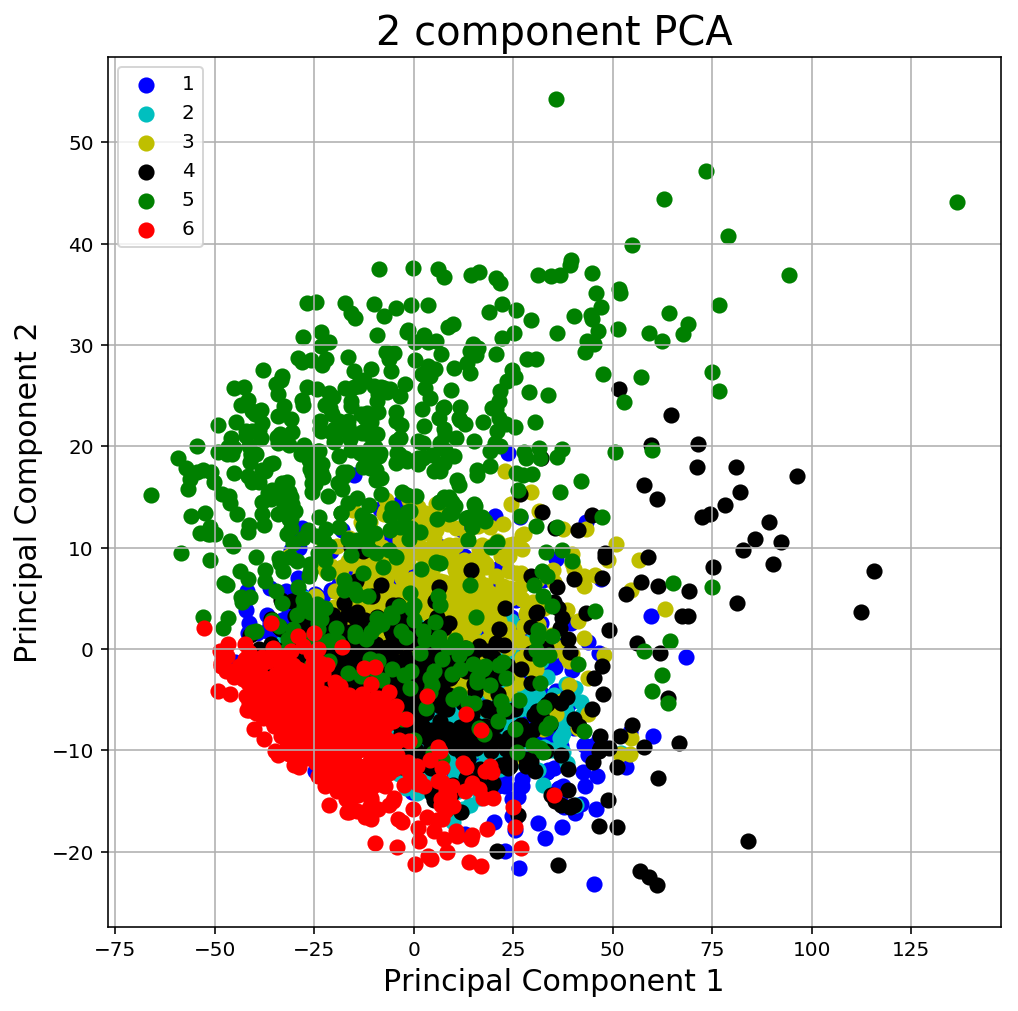

In [188]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = np.arange(1,7,1)
colors = ['b','c','y','k','g','r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [189]:
from sklearn.decomposition import PCA
import pandas as pd
pca_3 = PCA(n_components=3)
principalComponents_3 = pca_3.fit_transform(high_dim_feature)
principalDf_3 = pd.DataFrame(data = principalComponents_3
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
targets = pd.DataFrame(labels_all,columns=['target'])
finalDf_3 = pd.concat([principalDf_3, targets], axis = 1)


In [207]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib 
 

Using matplotlib backend: MacOSX


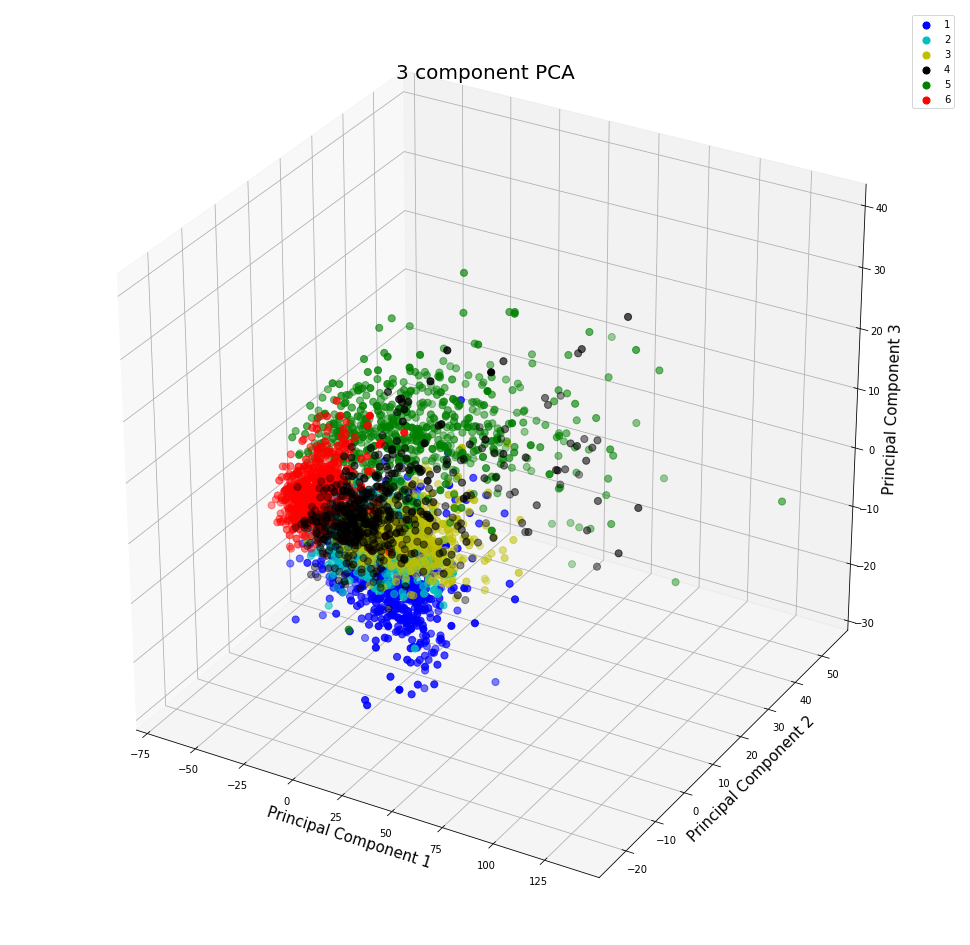

In [205]:
fig = plt.figure(figsize = (17,17))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title('3 component PCA', fontsize = 20)
targets = np.arange(1,7,1)
colors = ['b','c','y','k','g','r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_3['target'] == target
    ax.scatter(finalDf_3.loc[indicesToKeep, 'principal component 1']
               , finalDf_3.loc[indicesToKeep, 'principal component 2']
               , finalDf_3.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()